# Overview

This notebook will follow the presentation slides (from NICE 2024)
- Installation
- Quick start example
- Overview of basic configuration files (using predefined models)
    - Configuring neuron and synapse parameters
    - Configuring network connectivity structure
    - Configuring a simulation
    - Building a network and running a simulation
- Overview of intermediate functionality
    - Recording more than just spikes (state probes)
    - Python interface and inputs
    - Defining new neuron models
    - Defining new synapse models

# Installation

Installation proceeds in roughly the following order:
- Environment/dependencies
- Charm++
- STACS
- Python (for analysis)

We provide the instructions below for Linux and MacOS. Note that some dependencies may already be installed on your machine, or other ones may also be required. Follow the missing dependency errors you receive if that's the case.

## General development environment

### Linux
`sudo apt-get install build-essential gfortran cmake`  
`sudo apt-get install libyaml-cpp-dev libfftw3-dev`  
`sudo apt-get install mpich`

### MacOS
First install Homebrew: https://brew.sh/  
`brew install wget htop gcc cmake git`  
~~`brew install yaml-cpp fftw`~~  
`brew install mpich`

Note: for the STACS dependencies, the `yaml-cpp` and `fftw` packages from `brew` don't actually seem to provide the relevant header files needed for compiling and linking. Instead, these packages may need to be installed from source and the relevant environment variables set up. The process for this looks roughly like the following:

Clone yaml-cpp (from github)
`mkdir build`  
`cd build`  
`ccmake ../` (make sure the install prefix is set to where you want to install it)  
`make -j8`  
`make install`  

For fftw:  
`./configure --prefix=/path/to/where/to/install/fftw`  
`make -j8`  
`make install`  

If you don't want to use an install prefix, it will install in a default location (e.g. `/usr/local`), in which case, those paths need to be used below.

After installation, the following environment variables need to be set up (e.g. in `.bashrc`):
```sh
# yaml
export YAMLDIR=/path/to/yaml
export CPLUS_INCLUDE_PATH=$YAMLDIR/include:$CPLUS_INCLUDE_PATH
export LIBRARY_PATH=$YAMLDIR/lib:$LIBRARY_PATH
export LD_LIBRARY_PATH=$YAMLDIR/lib:$LD_LIBRARY_PATH

# fftw
export FFTWDIR=/path/to/fftw
export CPLUS_INCLUDE_PATH=$FFTWDIR/include:$CPLUS_INCLUDE_PATH
export LIBRARY_PATH=$FFTWDIR/lib:$LIBRARY_PATH
export LD_LIBRARY_PATH=$FFTWDIR/lib:$LD_LIBRARY_PATH
```


## Setting up Charm++
Clone repo from github: https://github.com/UIUC-PPL/charm  
Alternatively, get version 7.0.0 (available as tarball, zip)  
The `-j8` in the following commands allows the build process to use multiple threads in parallel.  
Feel free to replace '8' with what's appropriate for your machine.

### Linux
`./build charm++ mpi-linux-x86_64 -j8`

### MacOS
If on Apple silicon:  
`./build charm++ mpi-darwin-arm8 -j8`

If on Intel Mac: set the min version variable in the files in `charm/src/arch/mpi-darwin-x86_64` to `12.6`  
`./build charm++ mpi-darwin-x86_64 -j8`

### Both
Note: It's possible that the `build` command may not work on your machine (which uses CMake), in which case you can try the `buildold` command instead.

Set up associated environment variables (e.g. in `.bashrc`)  
`export PATH=/path/to/charm/bin:$PATH`

## STACS
Clone repo from github: https://github.com/sandialabs/STACS  
`make -j8`

## Python (for working with data)
Feel free to use your typical python environment (e.g. Anaconda), it just needs the YAML libraries to work with the STACS configuration files  
`pip install pyyaml`

# Quick Start Example

Once STACS is istalled, as an example, pre-built network to run, we'll use the network in `stacs/networks/polynet`, which is an 80/20 excitatory/inhibitory network with STDP (Izhikevich 2006)

## Copying over network configuration  
First we'll copy out the example configuration files into the main folder:  
`cp polynet/examples/polynet.yml.eg polynet/polynet.yml`  
`cp polynet/examples/polynet.graph.eg polynet/polynet.graph`  
`cp polynet/examples/polynet.model.eg polynet/polynet.model`

We'll also want to create a directory to store records:  
`mkdir polynet/record`

## Running network  
From the base directory of the STACS repository, we can launch STACS and point it to the network files:  
`./charmrun +p8 ./stacs ./networks/polynet/polynet.yml`

This will first build the network and then simulate it.  
An initial network snapshot will be saved in the networks/polynet directory, a final snapshot will also be saved (with a different filebase `polynet.out`), and event logs (of the spikes) will be saved in `networks/polynet/record`. For the event logs, spikes are stored as [event type, timestamp, index] per line (and spikes are type 0).

## Plotting output  
Although STACS has simulated the network, and recorded the simulation data, it doesn't actually have any method for offline analysis of the data. This is where we may import the data into Python for plotting the spike raster. We borrow the YAML parser to extract the relevant simulation configuration.

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yaml

matplotlib.rcParams.update({'font.size': 16})

In [2]:
# Network simulation yaml
stacsdir = '..'
configfile = stacsdir + '/' + 'networks/polynet/polynet.yml'
with open(configfile,"r") as file:
    simconfig = yaml.safe_load(file)
    
# Network and records directory
netwkdir = simconfig['netwkdir']
recordir = simconfig['netwkdir'] + '/' + simconfig['recordir']
print("Network directory: {}".format(netwkdir))

# Snapshot information
filebase = simconfig['filebase']
netfiles = int(simconfig['netfiles'])
netparts = int(simconfig['netparts'])
print("Network filebase: {}".format(filebase))
print("Number of files: {}".format(netfiles))
print("Number of parts: {}".format(netparts))

# Timing information
tmax = float(simconfig['tmax'])
tstep = float(simconfig['tstep'])
trecord = float(simconfig['trecord'])
print("Max simulation time: {}".format(tmax))
print("Simulation timestep: {}".format(tstep))
print("Recording interval: {}".format(trecord))

# Printing everything in config
# for part in simconfig:
#     print(part, simconfig[part])

Network directory: networks/polynet
Network filebase: polynet
Number of files: 4
Number of parts: 8
Max simulation time: 60000.0
Simulation timestep: 1.0
Recording interval: 10000.0


In [3]:
# Graph information (number of vertices)
graphfile = stacsdir + '/' + netwkdir + '/' + filebase + '.graph'
with open(graphfile,"r") as file:
    graphconfig = yaml.safe_load(file)

# Vertex population sizes
vertex_modname = []
vertex_order = []
for vertex in graphconfig['vertex']:
    vertex_modname.append(vertex['modname'])
    vertex_order.append(vertex['order'])
    print("Vertex model {} : {}".format(vertex['modname'], vertex['order']))
vertex_prefix = [0] + [sum(vertex_order[:i+1]) for i in range(len(vertex_order))]
print("Prefix sum: {}".format(vertex_prefix))

# Printing everything in graph  
# for part in graphconfig:
#     for p in graphconfig[part]:
#         print(part,p)

Vertex model izhiex : 800
Vertex model izhiin : 200
Vertex model izhithal : 1
Prefix sum: [0, 800, 1000, 1001]


In [4]:
# Because the neuron models are distributed over multiple partitions,
# we need to find the reindexing mapping for cleaner plotting
vertex_remap = np.zeros(vertex_prefix[-1]).astype(int)

# global and per-population counters
vertex_global_index = 0
vertex_model_index = np.zeros(len(vertex_modname)).astype(int)

# Loop through the state files
for fileidx in range(netfiles):
    fname = stacsdir + '/' + netwkdir + '/' + filebase + '.state.' + str(fileidx)
    with open(fname, 'r') as fstate:
        for line in fstate:
            # the vertex model name is the first word per line
            modname = line.split(None, 1)[0]
            vertex_remap[vertex_global_index] = vertex_prefix[vertex_modname.index(modname)] \
                                              + vertex_model_index[vertex_modname.index(modname)]
            vertex_global_index += 1
            vertex_model_index[vertex_modname.index(modname)] += 1

In [5]:
# Reading in data from event logs, which are stored 
# by recording interval in simulation iterations
record_interval = int(trecord/tstep)
record_max = int(tmax/tstep)
record_points = list(range(record_interval, record_max, record_interval))+[record_max]
print("Recording points: {}".format(record_points))

# Conversion from timestamp 'tick' to milliseconds
TICKS_PER_MS = 1000000

# Collect spikes into an event list
event_list = [[] for _ in range(vertex_prefix[-1])]
event_count = 0
for record in record_points:
    for fileidx in range(netfiles):
        fname = stacsdir + '/' + recordir + '/' + filebase + '.evtlog.' + str(record) + '.' + str(fileidx)
        with open(fname, 'r') as file:
            for line in file:
                # the event format is [event type, timestamp, vertex index, optional payload]
                event = line.split()
                event_type = int(event[0])
                timestamp = float(int(event[1], 16)) / TICKS_PER_MS
                global_index = int(event[2])
                # reindex the events
                index = int(vertex_remap[global_index])
                # spikes are event type "0"
                if event_type == 0:
                    event_list[index].append(timestamp)
                    event_count += 1

print("Total events: {}".format(event_count))

Recording points: [10000, 20000, 30000, 40000, 50000, 60000]
Total events: 343463


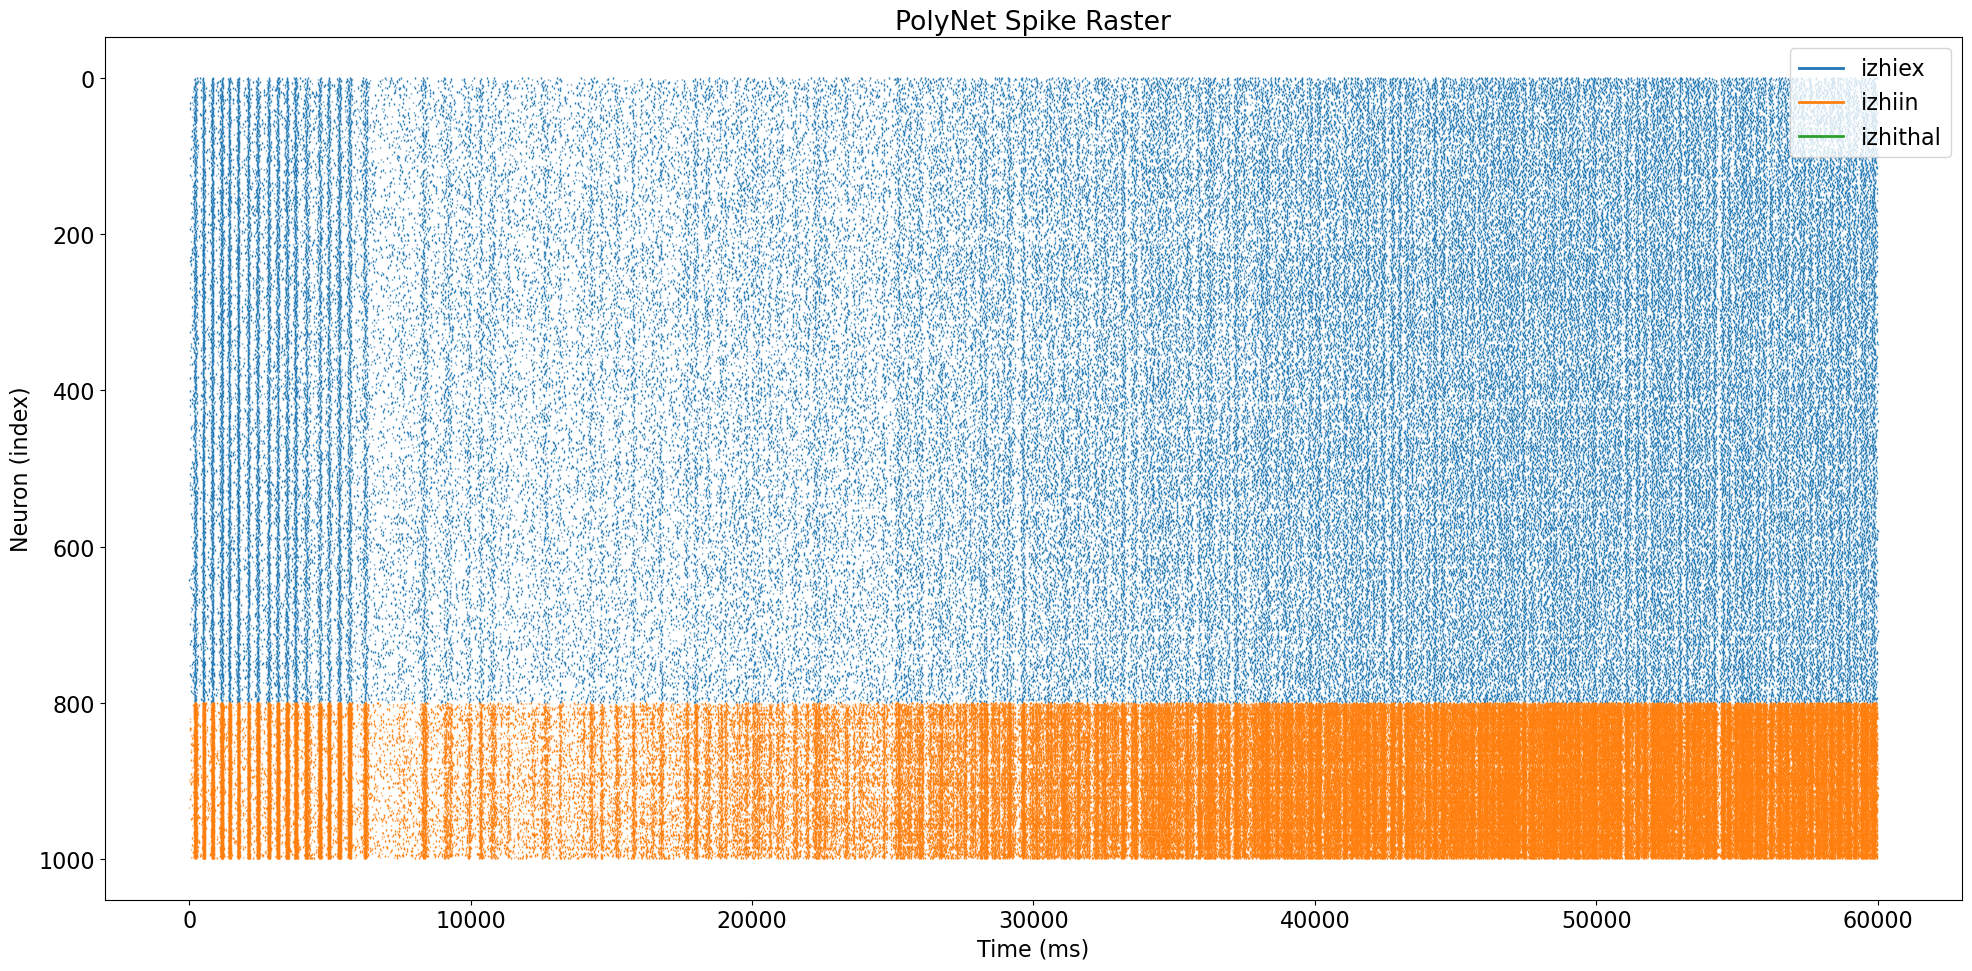

In [6]:
# Plot the event data
plt.figure(figsize=(20,10))

# We can also color the rows according to population
event_color = []
for model_index in range(len(vertex_modname)):
    event_color.extend(['C{}'.format(model_index)] * (vertex_prefix[model_index+1] - vertex_prefix[model_index]))
    # colored lines (just for display)
    plt.plot(0,0,'-',color='C{}'.format(model_index),linewidth=2.0,markersize=0.0)

# The spike raster is plotted using eventplot
plt.eventplot(event_list,colors=event_color,lineoffsets=1,linelengths=2.0,linewidths=1.0)

plt.title('PolyNet Spike Raster')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron (index)')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.legend(vertex_modname)

# Network Model Configuration Files

## Overview

A network model is composed of three YAML-formatted configuration files:
- The main config file sets up information related to how the network model will be processed by the simulator
- The network graph file defines the connectivity structure of the vertices and edges that compose the network
- The network substrate model file parameterizes the time- and event-driven dynamics used by the vertices and edges

## Main configuration file (`.yml`)

### Simulation
The simulation config variables concern with how STACS behaves.

Note: The development of STACS was driven by work on polychronizing networks in a robotics setting, so a number of the available features may not be as relevant for general purpose SNN simulation.

- `runmode`, which is the main relevant variable, can be chosen from the set [simulate, findgroup, and estimate], with the default being "simulate". 
- `randseed` sets a seed for repeatable execution (as long as network partitions are the same).
- `plastic` and `episodic` toggle some additional functionality to the simulation control loop.
- `rpcport` provides the YARP-based port address that STACS will listen to for RPC commands, and `rpcpause` toggles whether the simulator waits for the start command. These variables are ignored if the simulator is not compiled with YARP.

### Network
The network variables are related to how the network is stored and processed.

- `netwkdir` points to the directory where the data is stored, and `recordir` and `groupdir` are subdirectories in `netwkdir` where records and (polychronous) group information is stored
- `filebase` provides the base name of the network files, and `fileload` and `filesave` are suffixes to `filebase` for which files correspond to which network snapshot to read/write from/to during loading/saving, respectively
- `netfiles` declares how many different files the network is split between on disk, and `netparts` declares how many different partitions the network is split between in simulation

### Timing
The timing variables are related to how STACS manages the simulation time stepping. All units for the time variables are in milliseconds.

- `tstep` determines how long a simulation time step is, and `tmax` determines the max simulation time
- `teventq` (in conjunction with `tstep`) determines the size of the event queue for incoming events on a vertex
- `tdisplay` sets how often STACS gives an update (printed to STDOUT) on which iteration it's on
- `trecord` determines how often probed network data (e.g. generated events) are recorded to file
- `tsave` determines how often network state (i.e. full snapshot) is saved to disk
- `tepisode` determines how long an episodic trial is when run in `episodic` mode
- `episodes` determines how many episodic trials there are when run in `episodic` mode

## Graph file (`.graph`)

### Vertices
This section contains a list of each type of vertex model used by the network, which are uniquely identified by `modname` (this model name should correspond to the model definitions in the network model file).

For any given vertex model, there are some additional instantiation parameters with respect to the graph:

- `order` determines how many of the vertex model to instantiate, thus creating a population of said vertex model. Each of these instances are initialized based on information in the associated network model file.
- `shape` and related parameters such as `radius` and `coord` are used to specify the spatial location of the vertex (or vertices if order > 1).
  - These are useful for spatially dependent connectivity and partitioning. Options for `shape` include "point", "circle", and "sphere"
  - If location information is unnecessary, a "point" at coordinate [0.0, 0.0, 0.0] is the default.

### Streams
These are essentially a special type of vertex that contains information for real-time I/O through YARP. They are unique (`order = 1`), so only require a `modname` and `coord` to specify where they are in the network. They are connected to other vertices in the graph in the same way (through edge models).

### Edges
This section contains a list of each type of edge connecting the different vertex populations. These are uniquely identified by `source` and `target` populations, and how they are connected through an edge model (identified by `modname`).

Note: these define a directed graph, and given `source` and `target` pairing can currently only be specified to be connected with a single edge model.

For any given connection between vertices, we have the following parameters:

- `source` provides the `modname` of the sending vertex model/population (see the above), and `target` provides a list of `modname` of the receiving vertex model(s)/population(s)
- `modname` in the edge specification determines the edge model that is used to compute the connection dynamics (i.e. send/receive processing).
- `cutoff` is used when spatially dependent connectivity is used, and the default is 0.0 for no cutoff distance between any pair of vertices (where beyond that, the `connect` information is not evaluated).
- `connect` contains the information needed to determine whether to create a connection when evaluating a pair of source/target vertices.
	- `conntype` specifies the connection type based on probability distributions, for example [uniform, sigmoid, index].
	- Each connection type takes on certain parameters, such as `prob` and `slope`, that specify the probability distribution, or `srcoff` and `srcmul`, that specify index-based offsets/multipliers w.r.t. the source index.

## Model file (`.model`)

The network model file defines model parameters and state initialization details for the network substrate models (located in the `models` directory). These include model definitions for both vertex and edge models, and they are split up into different YAML "files" that are separated within the file using the `---` and `...` syntax.

### Substrate models
The model specifications follow the same general format regardless of whether or not the model pertains to a vertex or an edge (or a stream).

- `type` determines whether the model is for a [vertex, edge, stream]
- `modname` provides the unique model name that is used to differentiate between the different models that compose a given network
- `modtype` provides a reference to the underlying model dynamics that the model uses. Different models (with different `modname`) can reference to the same `modtype` (e.g. this is useful if you have the same type of neuron model that is used in multiple populations).
- `param` specifies model-specific parameters (as implemented by the `modtype` reference) that influence the model dynamics. These parameters are shared across all instances of `modname`, and are defined with of `name` and `value` pairs.
- `state` specifies instantiation details for model-specific state (as implemented by the `modtype` reference) that are either unique per model instantiation and/or are mutable throughout network simulation.
	- These are defined using a `name` and `init` (type of initialization):
		- `constant` takes a `value` that all instantiations are initialized with.
		- `uniform` and `normal` and its variants (e.g. over an interval) draw values from a specified probability distribution 
		- `linear` is proportional to distance
	- The `rep` (short for representation) of a given state selects between [real, tick] and determines whether the state is a real number or an integer-based value (used for timestamps)
- `port` specifications are unique to streams, and are used to open communication ports for I/O

### Records
A `record` "file"/section may optionally be included to set up event watchers or state probes

- `events` provides a list of event watchers (by default, this should have the `spike` event type)
- `probes` provides a list of state probes which are identified by:
    - `modname` is the model name of one of the included substrate models
    - `state` is the state name from the substrate model that should be recorded
    - `tfreq` is how often (in milliseconds) to record state values

# Recording state data

We can add the following recording information to the substrate `.model` configuration (and then rerun the network):
```yaml
---
type: record
events:
  - spike
probes:
  - tfreq: 1000.0
    modname: exstdp
    state: weight
...
```

In [7]:
# Reading in data from state probes, which are stored 
# by recording interval in simulation iterations
record_interval = int(trecord/tstep)
record_max = int(tmax/tstep)
record_points = list(range(record_interval, record_max, record_interval))+[record_max]
print("Recording points: {}".format(record_points))

# Conversion from timestamp 'tick' to milliseconds
TICKS_PER_MS = 1000000
header_offset = 5

# Substrate model information
modelfile = stacsdir + '/' + netwkdir + '/' + filebase + '.model'
modelconfig = []
with open(modelfile,"r") as file:
    yamlfiles = yaml.safe_load_all(file)
    for yamlfile in yamlfiles:
        modelconfig.append(yamlfile)
        
# Find how many records there are
record_types = 0
for model in modelconfig:
    if (model['type'] == 'record'):
        if ('probes' in model):
            record_types += len(model['probes'])
print("Number of record types: {}".format(record_types))

# Read in record files
record_index = []
record_data = []
for record in record_points:
    partidx = 0 # stored per partition
    prev_timestamp = 0 # for bookkeeping
    for fileidx in range(netfiles):
        fname = stacsdir + '/' + recordir + '/' + filebase + '.record.' + str(record) + '.' + str(fileidx)
        with open(fname, 'r') as file:
            for line in file:
                # record id, timestamp, real-valued, tick-valued, integer-valued
                data = line.split()
                record_id = int(data[0])
                timestamp = float(int(data[1], 16)) / TICKS_PER_MS
                num_real = int(data[2])
                num_tick = int(data[3])
                num_int = int(data[4])
                # Some partition-based bookkeeping
                if (timestamp < prev_timestamp):
                    partidx += 1
                prev_timestamp = timestamp
                # parse the header (first line in first record file, timestep = 0)
                if (timestamp == 0):
                    # create a new line for each record (by partidx and record_id)
                    record_index.append({})
                    record_index[record_types*partidx+record_id]['vtxidx'] = []
                    record_index[record_types*partidx+record_id]['edgidx'] = []
                    record_data.append({})
                    record_data[record_types*partidx+record_id]['timestamp'] = []
                    record_data[record_types*partidx+record_id]['values'] = []
                    for index in range(num_int//2):
                        record_index[record_types*partidx+record_id]['vtxidx'].append(int(data[header_offset+2*index]))
                        record_index[record_types*partidx+record_id]['edgidx'].append(int(data[header_offset+2*index+1]))
                # remaining lines are the data points
                else:
                    record_data[record_types*partidx+record_id]['timestamp'].append(timestamp)
                    record_data[record_types*partidx+record_id]['values'].append([])
                    for value in range(num_real):
                        record_data[record_types*partidx+record_id]['values'][-1].append(float(data[header_offset+value]))

Recording points: [10000, 20000, 30000, 40000, 50000, 60000]
Number of record types: 1


In [8]:
# how many entries and timestamps there are
record_id = 0
record_entries = 0
record_timestamps = len(record_data[record_id]['timestamp'])
for partidx in range(netparts):
    record_entries += len(record_index[record_types*partidx+record_id]['vtxidx'])
print("Record ID {}: {} x {} (timestamps x entries)".format(record_id, record_timestamps, record_entries))

Record ID 0: 60 x 80119 (timestamps x entries)


Text(0, 0.5, 'Weight')

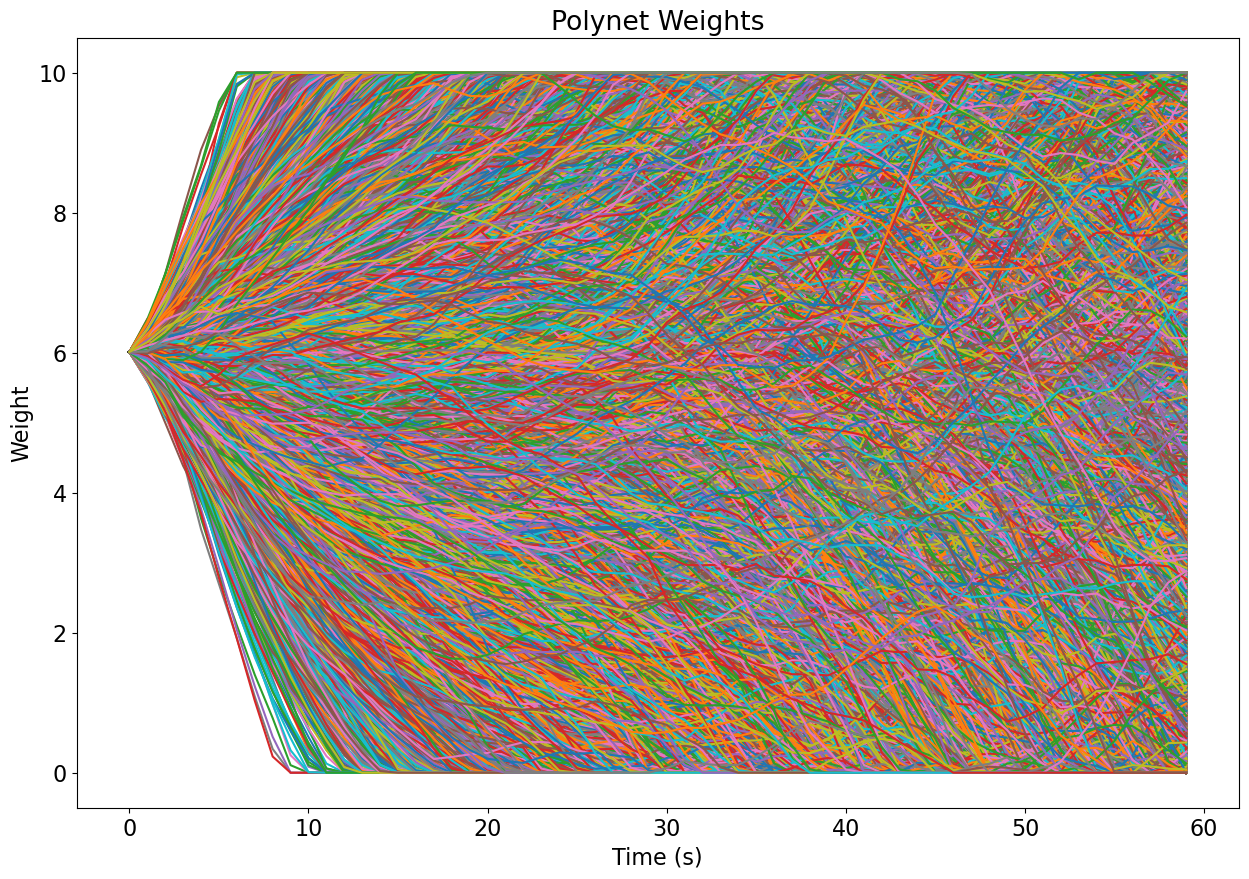

In [9]:
# We can move this list-format data into single array
record_array = np.hstack([np.array(record_data[record_types*partidx+record_id]['values'])
                          for partidx in range(netparts)])

# We can then plot the data
plt.figure(figsize=(15,10))
plt.plot(record_array)
plt.title('Polynet Weights')
plt.xlabel('Time (s)')
plt.ylabel('Weight')

# Spike Input Example

We can provide spikes into a network through an event list. This uses the `SpikeInput` stream model, which reads from a YAML-formatted file.

For this example, we use the network in `stacs/networks/polyrect`, and we'll copy out the example configuration files into their main folder:  
`cp polyrect/examples/polynet.yml.eg polyrect/polynet.yml`  
`cp polyrect/examples/polynet.graph.eg polyrect/polynet.graph`  
`cp polyrect/examples/polynet.model.eg polyrect/polynet.model`  
`mkdir polyrect/record`

In [10]:
# Write this to an input file
# We use a different network for this
stacsdir = '..'
configfile = stacsdir + '/' + 'networks/polyrect/polynet.yml'
with open(configfile,"r") as file:
    simconfig = yaml.safe_load(file)
    
# Network and records directory
netwkdir = simconfig['netwkdir']
recordir = simconfig['netwkdir'] + '/' + simconfig['recordir']
print("Network directory: {}".format(netwkdir))

# Snapshot information
filebase = simconfig['filebase']
netfiles = int(simconfig['netfiles'])
netparts = int(simconfig['netparts'])
print("Network filebase: {}".format(filebase))
print("Number of files: {}".format(netfiles))
print("Number of parts: {}".format(netparts))

# Timing information
tmax = float(simconfig['tmax'])
tstep = float(simconfig['tstep'])
trecord = float(simconfig['trecord'])
print("Max simulation time: {}".format(tmax))
print("Simulation timestep: {}".format(tstep))
print("Recording interval: {}".format(trecord))

Network directory: networks/polyrect
Network filebase: polynet
Number of files: 8
Number of parts: 8
Max simulation time: 60000.0
Simulation timestep: 1.0
Recording interval: 10000.0


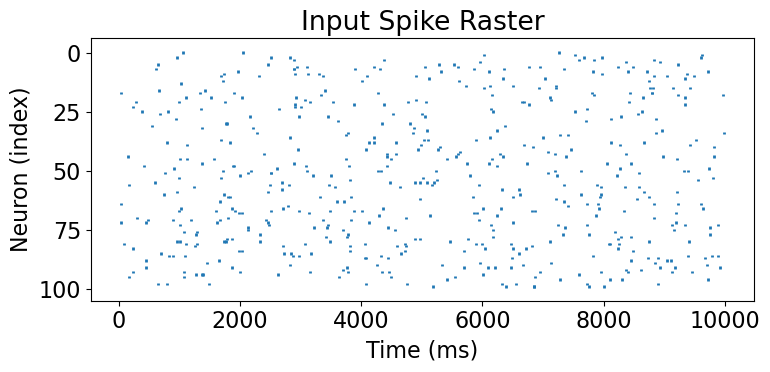

In [11]:
# We construct an event list and supply it to a YAML dictionary,
# where timestamps are provided in milliseconds
num_inputs = 100
time_inputs = 10000.0 # ms

# We model a poisson input
spike_rate = 2.0 # Hz
ave_spikes = time_inputs / (spike_rate * 1000.0)
spike_list = []
np.random.seed(2024)
for neuron in range(num_inputs):
    num_spikes = np.random.poisson(ave_spikes)
    timestamps = np.sort(np.round(np.random.rand(num_spikes)*time_inputs))
    spike_list.append(timestamps.tolist())

# Plot the event data
plt.figure(figsize=(8,4))
plt.eventplot(spike_list,lineoffsets=1,linelengths=1.0,linewidths=2.0)
plt.title('Input Spike Raster')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron (index)')
plt.tight_layout()
plt.gca().invert_yaxis()

In [12]:
# Write this spike list to an input file
yaml_input = {}
yaml_input["spike_list"] = spike_list

inputfile = stacsdir + '/' + netwkdir + '/' + 'input.yml'
with open(inputfile,'w') as file:
    yaml.dump(yaml_input,file)

In [13]:
# We can also run STACS through Python
import subprocess

# Here, we provide paths relative to the STACS directory
stacsdir = '..'
charmrun = './charmrun'
charm_pe = '+p8'
stacsbin = './stacs'
netconf = 'networks/polyrect/polynet.yml'
runmode = 'buildsim'

# Command to run (as list)
runcmd = charmrun + ' ' + charm_pe + ' ' + stacsbin + ' ' + netconf + ' ' + runmode
print(runcmd)

# Use subprocess to run
subprocess.run(runcmd.split(), cwd=stacsdir)

./charmrun +p8 ./stacs networks/polyrect/polynet.yml buildsim

Running as 8 OS processes:  ./stacs networks/polyrect/polynet.yml buildsim 
charmrun> mpirun -np 8  ./stacs networks/polyrect/polynet.yml buildsim 
Charm++> Running on MPI version: 4.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in non-SMP mode: 8 processes (PEs)
Converse/Charm++ Commit ID: v70000
Charm++ built without optimization.
Do not use for performance benchmarking (build with --with-production to do so).
Charm++ built with internal error checking enabled.
Do not use for performance benchmarking (build without --enable-error-checking to do so).
Isomalloc> Synchronized global address space.
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 12 cores x 1 PUs = 12-way SMP)
Charm++> cpu topology info is gathered in 0.007 seconds.

Simulation Tool for Asynchronous Cortical Streams (stacs)
Reading config from networks/polyrect/polynet.yml
  loadbal not def

CompletedProcess(args=['./charmrun', '+p8', './stacs', 'networks/polyrect/polynet.yml', 'buildsim'], returncode=0)

In [14]:
# Graph information (number of vertices)
graphfile = stacsdir + '/' + netwkdir + '/' + filebase + '.graph'
with open(graphfile,"r") as file:
    graphconfig = yaml.safe_load(file)

# Vertex population sizes
vertex_modname = []
vertex_order = []
# Section for vertices
for vertex in graphconfig['vertex']:
    vertex_modname.append(vertex['modname'])
    vertex_order.append(vertex['order'])
    print("Vertex model {} : {}".format(vertex['modname'], vertex['order']))
# Section for streams
for vertex in graphconfig['stream']:
    vertex_modname.append(vertex['modname'])
    vertex_order.append(1)
    print("Vertex model {} : {}".format(vertex['modname'], 1))
vertex_prefix = [0] + [sum(vertex_order[:i+1]) for i in range(len(vertex_order))]
print("Prefix sum: {}".format(vertex_prefix))

Vertex model izhi_input : 100
Vertex model izhiex : 4000
Vertex model izhiin : 1000
Vertex model spike_input : 1
Prefix sum: [0, 100, 4100, 5100, 5101]


In [15]:
# Because the neuron models are distributed over multiple partitions,
# we need to find the reindexing mapping for cleaner plotting
vertex_remap = np.zeros(vertex_prefix[-1]).astype(int)

# global and per-population counters
vertex_global_index = 0
vertex_model_index = np.zeros(len(vertex_modname)).astype(int)

# Loop through the state files
for fileidx in range(netfiles):
    fname = stacsdir + '/' + netwkdir + '/' + filebase + '.state.' + str(fileidx)
    with open(fname, 'r') as fstate:
        for line in fstate:
            # the vertex model name is the first word per line
            modname = line.split(None, 1)[0]
            vertex_remap[vertex_global_index] = vertex_prefix[vertex_modname.index(modname)] \
                                              + vertex_model_index[vertex_modname.index(modname)]
            vertex_global_index += 1
            vertex_model_index[vertex_modname.index(modname)] += 1

In [16]:
# Reading in data from event logs, which are stored 
# by recording interval in simulation iterations
record_interval = int(trecord/tstep)
record_max = int(tmax/tstep)
record_points = list(range(record_interval, record_max, record_interval))+[record_max]
print("Recording points: {}".format(record_points))

# Conversion from timestamp 'tick' to milliseconds
TICKS_PER_MS = 1000000

# Collect spikes into an event list
event_list = [[] for _ in range(vertex_prefix[-1])]
event_count = 0
for record in record_points:
    for fileidx in range(netfiles):
        fname = stacsdir + '/' + recordir + '/' + filebase + '.evtlog.' + str(record) + '.' + str(fileidx)
        with open(fname, 'r') as file:
            for line in file:
                # the event format is [event type, timestamp, vertex index, optional payload]
                event = line.split()
                event_type = int(event[0])
                timestamp = float(int(event[1], 16)) / TICKS_PER_MS
                global_index = int(event[2])
                # reindex the events
                index = int(vertex_remap[global_index])
                # spikes are event type "0"
                if event_type == 0:
                    event_list[index].append(timestamp)
                    event_count += 1

print("Total events: {}".format(event_count))

Recording points: [10000, 20000, 30000, 40000, 50000, 60000]
Total events: 449868


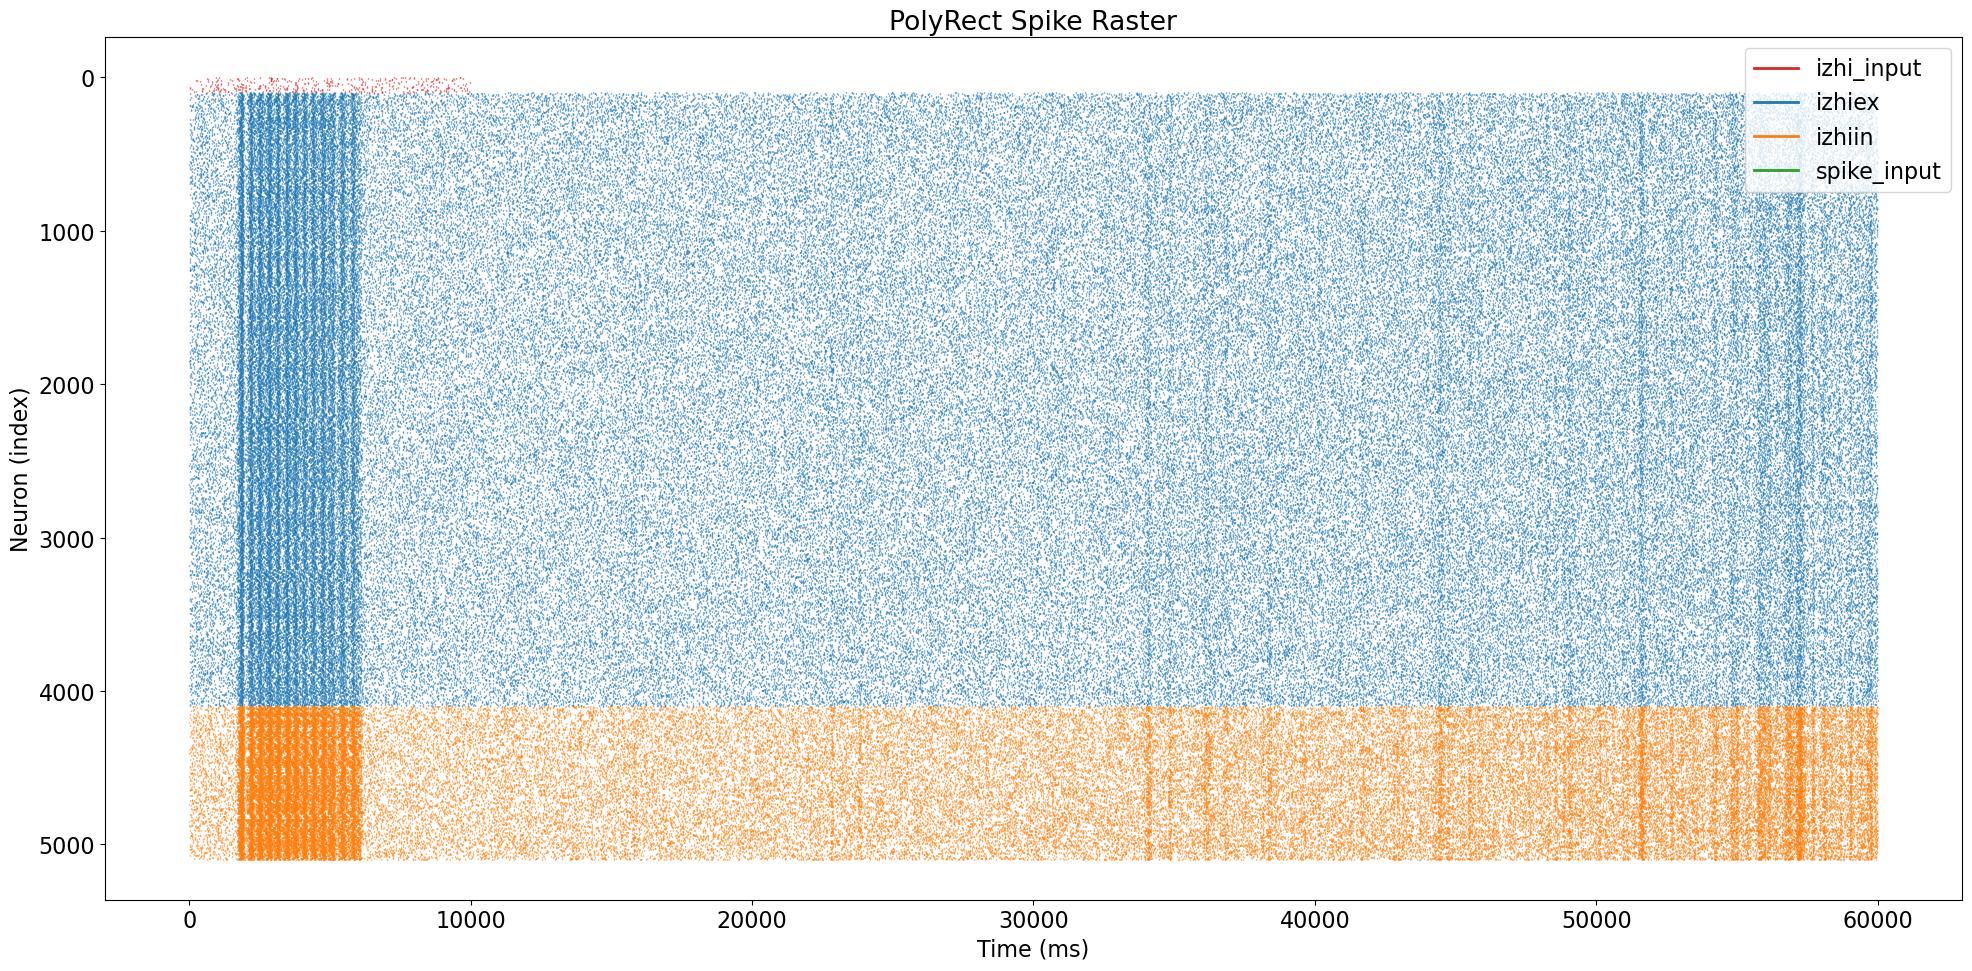

In [17]:
# Plot the event data
plt.figure(figsize=(20,10))

# We can also color the rows according to population
event_color = []
for model_index in range(len(vertex_modname)):
    # we cycle the colors backward to keep same color scheme as earlier
    event_color.extend(['C{}'.format((model_index-1)%len(vertex_modname))] * (vertex_prefix[model_index+1] 
                                                                              - vertex_prefix[model_index]))
    # colored lines (just for display)
    plt.plot(0,0,'-',color='C{}'.format((model_index-1)%len(vertex_modname)),linewidth=2.0,markersize=0.0)

# The spike raster is plotted using eventplot
plt.eventplot(event_list,colors=event_color,lineoffsets=1,linelengths=5.0,linewidths=1.0)

plt.title('PolyRect Spike Raster')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron (index)')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.legend(vertex_modname)

# Developing an Example Network Model

Here, we look at a network model found in the Brian simulator (Goodman 2008) from an SNN simulator survery (Brette 2007).
- This is an 80/20 reservoir network of 4000 leaky-integrate-and-fire (LIF) neurons
- With uniformly connected current-based (CUBA) exponentially decaying synapses
- We will be developing the neuron and synapse models for this network
- We will then bring these models into the network configuration files

## Network Equations

There are two neuron populations:
- `Pe = 3200` (excitatory)
- `Pi = 800` (inhibitory)

The neuron dynamics are defined as:  
- `dv/dt = (ge + gi + (E_L - v))/tau_m`  
- `dge/dt = -ge/tau_ge`  
- `dgi/dt = -gi/tau_gi`

The various parameters are:  
- `v_thresh = -50.0` (mV)
- `v_reset = -60.0` (mV)
- `E_L = -49.0` (mV)
- `tau_m = 20.0` (ms)
- `tau_ge = 5.0` (ms)
- `tau_gi = 10.0` (ms)

The synapse connectivity is:
- `Pe -> Pe, Pi` with probability `p = 0.02` and uniform weights `w = 1.62` (mV)
- `Pi -> Pe, Pi` with probability `p = 0.02` and uniform weights `w = -9.0` (mV)

There are initial membrane voltages:
- `v = uniform([-60, -50])` (init, mV)

The simulation timestep was 

## Modeling in STACS

### Neuron Model
We can declare a new class (e.g. `BretteNeuron`), which uses the `ModelTmpl` factory method:  
```cpp
class BretteNeuron : public ModelTmpl < 55, BretteNeuron >
```

For the neuron model, we note that there are:
- 3 states (`v, ge, gi`)
- 6 parameters (`v_thresh, v_reset, E_L, tau_m, tau_ge, tau_gi`)

We can use this to populate the `paramlist` and `statelist`:
- `paramlist`
    - `param[0] = v_thresh`
    - `param[1] = v_reset`
    - `param[2] = E_L`
    - `param[3] = tau_m`
    - `param[4] = tau_ge`
    - `param[5] = tau_gi`
- `statelist`
    - `state[0] = v`
    - `state[1] = ge`
    - `state[2] = gi`

Within the `Step` function, we can supply the neuron dynamics (simple forward Euler):  
```cpp
// get the real-valued timestep
real_t tstep = ((real_t) tdiff)/TICKS_PER_MS;
// v[t+1] = v[t] + dt * ((ge[t] + gi[t] + (E_L - v[t])) / tau_m)
state[0] = state[0] + tstep * ((state[1] + state[2] + (param[2] - state[0])) / param[3]);
// ge[t+1] = ge[t] - dt * (ge / tau_ge)
state[1] = state[1] - tstep * (state[1] / param[4]);
// gi[t+1] = gi[t] - dt * (gi / tau_gi)
state[2] = state[2] - tstep * (state[2] / param[5]);
```

We can check if the voltage crossed the threshold:  
```cpp
// check if spike occurred
if (state[0] > param[0]) {
    // reset states
    state[0] = param[1];
    state[1] = 0 
    state[2] = 0 

    // generate spike
    event_t event;
    event.diffuse = tdrift;
    event.type = EVENT_SPIKE;
    event.source = REMOTE_EDGES;
    event.index = 0;
    event.data = 0.0;
    events.push_back(event);
}
```

Finally we return how much time we integrated through:
```cpp
return tdiff;
```

### Synapse Models
Because there are two state variables (`ge, gi`) that the synapses may target, we actually need a model for each:
```cpp
class BretteSynGe : public ModelTmpl < 56, BretteSynGe >
class BretteSynGi : public ModelTmpl < 57, BretteSynGi >
```

The synapse models don't have any parameters, but they have a `weight` and `delay`:
- `statelist`
    - `state[0] = weight`
- `sticklist`
    - `stick[0] = delay`
    
There is also an auxiliary state that gets referenced in the neuron (`ge, gi`), respectively:
- `auxstate` (in BretteSynGe)
    - `auxidx[0] = ge`
- `auxstate` (in BretteSynGi)
    - `auxidx[0] = gi`
    
Within the `Jump` function, we add weights to (`ge, gi`) when we receive an incoming spike:
```cpp
// incoming spike event
// event.source contains the source neuron index
// event.index contains the local synapse index
if (event.type == EVENT_SPIKE && event.source >= 0) {
    // apply effect to target neuron
    // neuron.ge += synapse.weight
    state[0][auxidx[0].stateidx[0]] += state[event.index][0];
}
```

After these model files have been written, they need to be compiled. This is done simply by running `make` again from the base STACS directory (which only processes these new model files).

## Configuring the Network Model

### Substrate model file
We can provide the neuron parameters for the different neuron populations (`Pe` shown below):
```yaml
---
type: vertex
modname: pe
modtype: 55
param:
  - name: v_thresh
    value: -50.0
  - name: v_reset
    value: -60.0
  - name: E_L 
    value: -49.0
  - name: tau_m
    value: 20.0
  - name: tau_ge
    value: 5.0 
  - name: tau_gi
    value: 10.0
state:
  - name: v
    init: uniform
    min: -60.0
    max: -50.0
  - name: ge
    init: constant
    value: 0.0 
  - name: gi
    init: constant
    value: 0.0 
...
```

For the synapse models, we provide their different weights.  
We set the delay to the "next" timestep (the delay was "instantaneous" in original model):
```yaml
---
type: edge
modname: ce
modtype: 56
param:
state:
  - name: delay
    init: constant
    rep: tick
    value: 0.1
  - name: weight
    init: constant
    value: 1.62
---
type: edge
modname: ci
modtype: 57
param:
state:
  - name: delay
    init: constant
    rep: tick
    value: 0.1
  - name: weight
    init: constant
    value: -9.0
```

### Graph file
In the graph file, we set up how large the neuron populations are and how they connect to each other:

```yaml
vertex:
  - modname: pe
    order: 3200
    shape: point
    coord: [0.0, 0.0, 0.0]
  - modname: pi
    order: 800 
    shape: point
    coord: [0.0, 0.0, 0.0]

edge:
  - source: pe
    target: [pe, pi] 
    modname: ce
    cutoff: 100.0
    connect:
      - type: uniform
        prob: 0.02
  - source: pi
    target: [pe, pi] 
    modname: ci
    cutoff: 100.0
    connect:
      - type: uniform
        prob: 0.02
```

### Main simulation file
Here, the main differences from earlier examples will be the timing information:

```yaml
# simulation
runmode : "simulate"
randseed: 2024
plastic : no
episodic: no
loadbal : no
rpcport : "/stacs/rpc"
rpcpause: no

# network
netwkdir: "networks/brette2007"
netparts: 8 # 8 network partitions
netfiles: 1 # 1 network data files
filebase: "brette2007"
fileload: ""
filesave: ".out"
recordir: "record"
groupdir: "group"

# timing
tstep   : 0.1 # 0.1 millisecond
teventq : 1.0 # 1 millisecond
tdisplay: 100.0 # 100 milliseconds
trecord : 10000.0 # 10 seconds (not used)
tsave   : 60000.0 # 1 minute (not used)
tmax    : 1000.0 # 1 second
```

In [18]:
# Write this to an input file
# We use a different network for this
stacsdir = '..'
configfile = stacsdir + '/' + 'networks/brette2007/brette2007.yml'
with open(configfile,"r") as file:
    simconfig = yaml.safe_load(file)
    
# Network and records directory
netwkdir = simconfig['netwkdir']
recordir = simconfig['netwkdir'] + '/' + simconfig['recordir']
print("Network directory: {}".format(netwkdir))

# Snapshot information
filebase = simconfig['filebase']
netfiles = int(simconfig['netfiles'])
netparts = int(simconfig['netparts'])
print("Network filebase: {}".format(filebase))
print("Number of files: {}".format(netfiles))
print("Number of parts: {}".format(netparts))

# Timing information
tmax = float(simconfig['tmax'])
tstep = float(simconfig['tstep'])
trecord = float(simconfig['trecord'])
print("Max simulation time: {}".format(tmax))
print("Simulation timestep: {}".format(tstep))
print("Recording interval: {}".format(trecord))

Network directory: networks/brette2007
Network filebase: brette2007
Number of files: 1
Number of parts: 8
Max simulation time: 1000.0
Simulation timestep: 0.1
Recording interval: 10000.0


In [19]:
# We can also run STACS through Python
import subprocess

# Here, we provide paths relative to the STACS directory
stacsdir = '..'
charmrun = './charmrun'
charm_pe = '+p8'
stacsbin = './stacs'
netconf = 'networks/brette2007/brette2007.yml'
runmode = 'buildsim'

# Command to run (as list)
runcmd = charmrun + ' ' + charm_pe + ' ' + stacsbin + ' ' + netconf + ' ' + runmode
print(runcmd)

# Use subprocess to run
subprocess.run(runcmd.split(), cwd=stacsdir)

./charmrun +p8 ./stacs networks/brette2007/brette2007.yml buildsim

Running as 8 OS processes:  ./stacs networks/brette2007/brette2007.yml buildsim 
charmrun> mpirun -np 8  ./stacs networks/brette2007/brette2007.yml buildsim 
Charm++> Running on MPI version: 4.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in non-SMP mode: 8 processes (PEs)
Converse/Charm++ Commit ID: v70000
Charm++ built without optimization.
Do not use for performance benchmarking (build with --with-production to do so).
Charm++ built with internal error checking enabled.
Do not use for performance benchmarking (build without --enable-error-checking to do so).
Isomalloc> Synchronized global address space.
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 12 cores x 1 PUs = 12-way SMP)
Charm++> cpu topology info is gathered in 0.007 seconds.

Simulation Tool for Asynchronous Cortical Streams (stacs)
Reading config from networks/brette2007/brette2007.y

CompletedProcess(args=['./charmrun', '+p8', './stacs', 'networks/brette2007/brette2007.yml', 'buildsim'], returncode=0)

In [20]:
# Graph information (number of vertices)
graphfile = stacsdir + '/' + netwkdir + '/' + filebase + '.graph'
with open(graphfile,"r") as file:
    graphconfig = yaml.safe_load(file)

# Vertex population sizes
vertex_modname = []
vertex_order = []
# Section for vertices
for vertex in graphconfig['vertex']:
    vertex_modname.append(vertex['modname'])
    vertex_order.append(vertex['order'])
    print("Vertex model {} : {}".format(vertex['modname'], vertex['order']))
vertex_prefix = [0] + [sum(vertex_order[:i+1]) for i in range(len(vertex_order))]
print("Prefix sum: {}".format(vertex_prefix))

Vertex model pe : 3200
Vertex model pi : 800
Prefix sum: [0, 3200, 4000]


In [21]:
# Because the neuron models are distributed over multiple partitions,
# we need to find the reindexing mapping for cleaner plotting
vertex_remap = np.zeros(vertex_prefix[-1]).astype(int)

# global and per-population counters
vertex_global_index = 0
vertex_model_index = np.zeros(len(vertex_modname)).astype(int)

# Loop through the state files
for fileidx in range(netfiles):
    fname = stacsdir + '/' + netwkdir + '/' + filebase + '.state.' + str(fileidx)
    with open(fname, 'r') as fstate:
        for line in fstate:
            # the vertex model name is the first word per line
            modname = line.split(None, 1)[0]
            vertex_remap[vertex_global_index] = vertex_prefix[vertex_modname.index(modname)] \
                                              + vertex_model_index[vertex_modname.index(modname)]
            vertex_global_index += 1
            vertex_model_index[vertex_modname.index(modname)] += 1

In [22]:
# Reading in data from event logs, which are stored 
# by recording interval in simulation iterations
record_interval = int(trecord/tstep)
record_max = int(tmax/tstep)
record_points = list(range(record_interval, record_max, record_interval))+[record_max]
print("Recording points: {}".format(record_points))

# Conversion from timestamp 'tick' to milliseconds
TICKS_PER_MS = 1000000

# Collect spikes into an event list
event_list = [[] for _ in range(vertex_prefix[-1])]
event_count = 0
for record in record_points:
    for fileidx in range(netfiles):
        fname = stacsdir + '/' + recordir + '/' + filebase + '.evtlog.' + str(record) + '.' + str(fileidx)
        with open(fname, 'r') as file:
            for line in file:
                # the event format is [event type, timestamp, vertex index, optional payload]
                event = line.split()
                event_type = int(event[0])
                timestamp = float(int(event[1], 16)) / TICKS_PER_MS
                global_index = int(event[2])
                # reindex the events
                index = int(vertex_remap[global_index])
                # spikes are event type "0"
                if event_type == 0:
                    event_list[index].append(timestamp)
                    event_count += 1

print("Total events: {}".format(event_count))

Recording points: [10000]
Total events: 22998


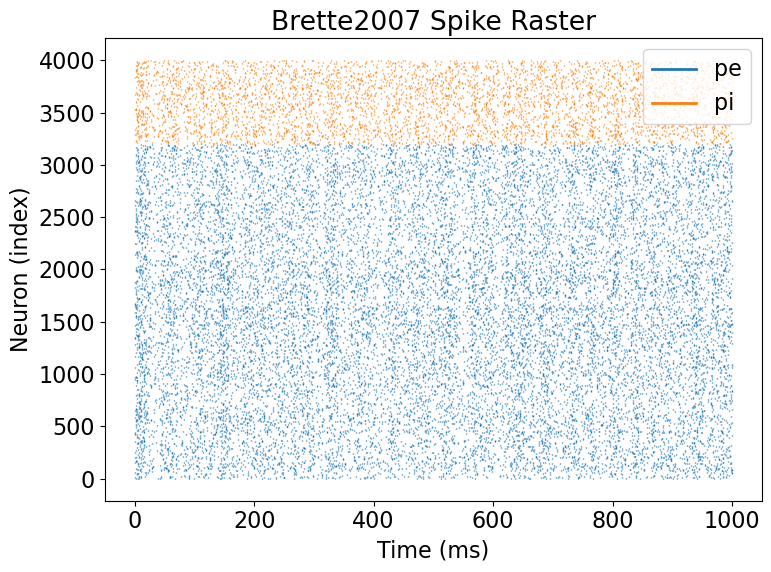

In [23]:
# Plot the event data
plt.figure(figsize=(8,6))

# We can also color the rows according to population
event_color = []
for model_index in range(len(vertex_modname)):
    # we cycle the colors backward to keep same color scheme as earlier
    event_color.extend(['C{}'.format(model_index)] * (vertex_prefix[model_index+1] - vertex_prefix[model_index]))
    # colored lines (just for display)
    plt.plot(0,0,'-',color='C{}'.format(model_index),linewidth=2.0,markersize=0.0)

# The spike raster is plotted using eventplot
plt.eventplot(event_list,colors=event_color,lineoffsets=1,linelengths=10.0,linewidths=1.0)

plt.title('Brette2007 Spike Raster')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron (index)')
plt.tight_layout()
plt.legend(vertex_modname)